# 异常值处理

异常值分为两种：（1）不符合题目条件的，如：指定汽车功率0～600，却有1000多的值（2）超出一定范围的

处理方法：
          针对1（1）训练集删除异常值，测试集进行长尾截断；或全部用NAN替换当成缺失值处理
         
          针对2（2）第一种是箱线图来处理，但如果把箱子拉长很多，还是有很多的界外值，这种方法显然不太好；考虑不作处理（或者进行转换查看异常值聚集点，考虑有什么实际意义？如果训练集与测试集一样那可能就是普遍现象不用管）
          
注：预处理之前先进行数据集的合并，再减少内存，查看各个特征的分布情况（head、tail；describe查看各数据分位数、方差等；info查看特征的类型、非空情况）

In [1]:
# 引入一些包
%matplotlib inline
import numpy as np 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 数据读取
path = 'I:/old_cars/data/'
Train_data = pd.read_csv(path + 'used_car_train_20200313.csv', sep=' ')
Test_data = pd.read_csv(path + 'used_car_testA_20200313.csv', sep=' ')

In [3]:
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)

In [4]:
# 顿号抑制输出
Train_data.head().append(Train_data.tail());
Test_data.head().append(Test_data.tail());

In [5]:
# 查看训练集和测试集形状，只有target（price）列缺失
print(Train_data.shape,Test_data.shape)

(150000, 31) (50000, 30)


In [6]:
# counts\std\quantile\st.
Train_data.describe();
Test_data.describe();

In [7]:
# feature dtype;有无缺失值
Train_data.info();
Test_data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 31 columns):
SaleID               150000 non-null int64
name                 150000 non-null int64
regDate              150000 non-null int64
model                149999 non-null float64
brand                150000 non-null int64
bodyType             145494 non-null float64
fuelType             141320 non-null float64
gearbox              144019 non-null float64
power                150000 non-null int64
kilometer            150000 non-null float64
notRepairedDamage    150000 non-null object
regionCode           150000 non-null int64
seller               150000 non-null int64
offerType            150000 non-null int64
creatDate            150000 non-null int64
price                150000 non-null int64
v_0                  150000 non-null float64
v_1                  150000 non-null float64
v_2                  150000 non-null float64
v_3                  150000 non-null float64
v_4       

In [8]:
# 查看price列的数据情况
Train_data['price'].value_counts();


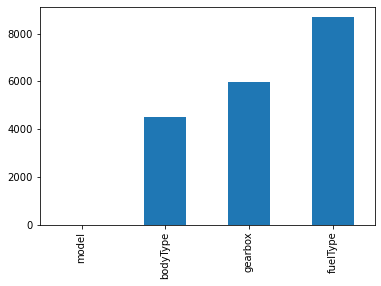

In [9]:
import missingno as msno
# nan可视化
missing = Train_data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

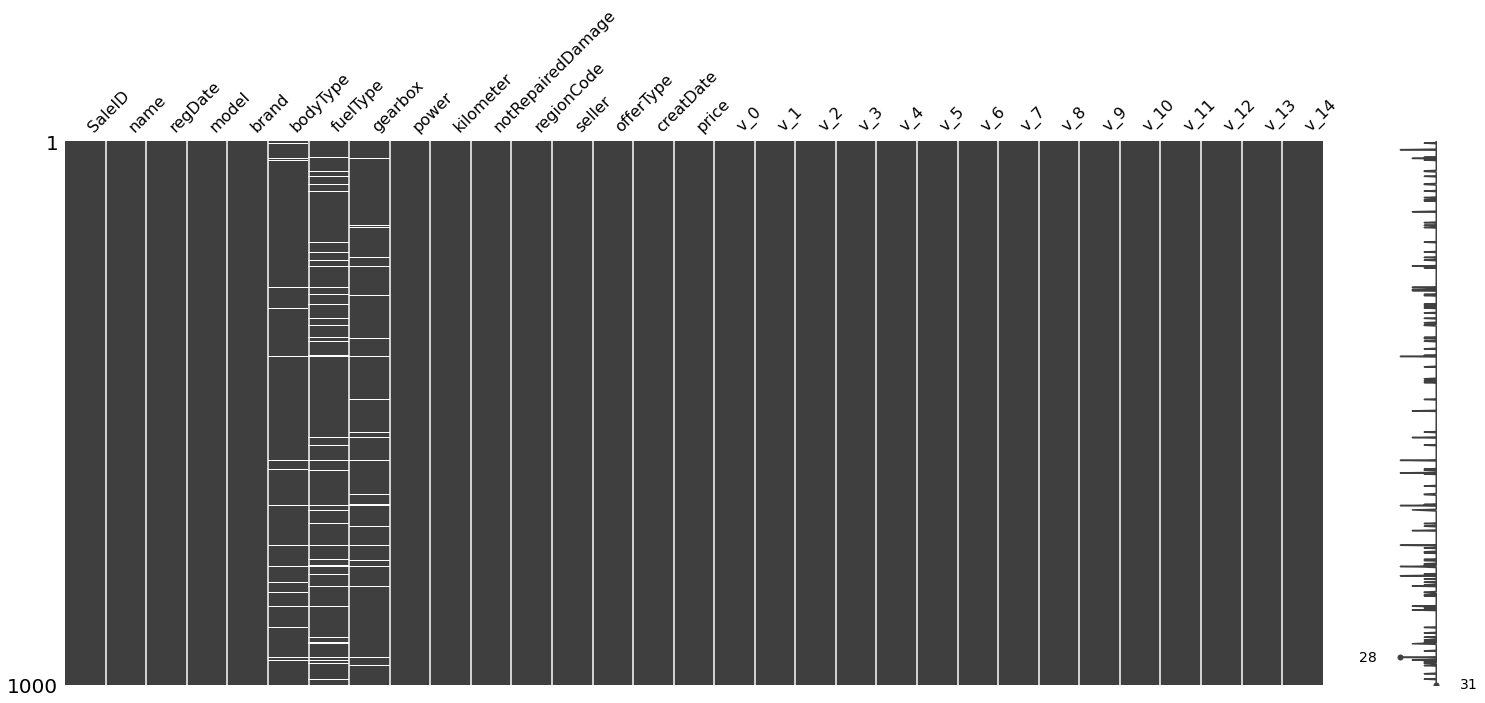

In [10]:
# 查看缺省值
msno.matrix(Train_data.sample(1000))

In [11]:
Train_data.skew(), Train_data.kurt()

(SaleID          0.000000
 name            0.557606
 regDate         0.028495
 model           1.484388
 brand           1.150760
 bodyType        0.991530
 fuelType        1.595486
 gearbox         1.317514
 power          65.863178
 kilometer      -1.525921
 regionCode      0.688881
 seller        387.298335
 offerType       0.000000
 creatDate     -79.013310
 price           3.346487
 v_0            -1.316712
 v_1             0.359454
 v_2             4.842556
 v_3             0.106292
 v_4             0.367989
 v_5            -4.737094
 v_6             0.368073
 v_7             5.130233
 v_8             0.204613
 v_9             0.419501
 v_10            0.025220
 v_11            3.029146
 v_12            0.365358
 v_13            0.267915
 v_14           -1.186355
 dtype: float64, SaleID            -1.200000
 name              -1.039945
 regDate           -0.697308
 model              1.740483
 brand              1.076201
 bodyType           0.206937
 fuelType           5.880049
 

直接画图看一下，发现事情确实不简单，这看上去是个不太好预测的分布，跟正态分布相差有一点远，远处的离群点看起来还不少，
训练起来误差估计会很大，这些离群点没办法准确预测，训练的时候可以考虑去掉，
但如果测试集也有类似的点，那就没办法了，回归场景里面一个离群点带来的误差就能拖垮整个数据集上的指标分数。

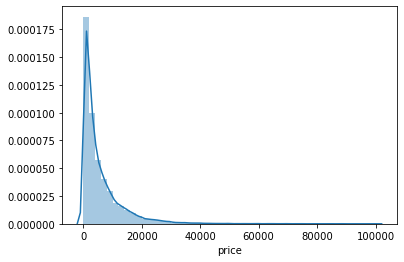

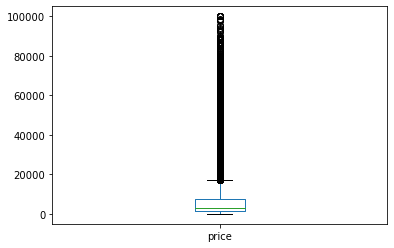

In [12]:
plt.figure()
sns.distplot(Train_data['price'])
plt.figure()
# 箱线图查看
Train_data['price'].plot.box()
plt.show()

In [13]:
# 查看异常值有多少？大于8万66个，大于60000的250个，大于5万的438个，大于450006的640个，大于4万的909个
len(Train_data[Train_data['price']>80000])
# Train_data[Train_data['price']>60000]

66

In [14]:
 Train_data[Train_data['price']>60000]

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,offerType,creatDate,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
163,163,59850,20140912,19.0,24,5.0,0.0,0.0,340,1.0,0.0,4543,0,0,20160404,66666,49.704053,-3.296455,0.906946,-4.563580,-1.383056,0.278829,0.001145,0.128137,0.130283,0.012128,0.434731,-4.693539,6.227460,-0.999634,1.110670
377,377,143408,20120606,167.0,24,4.0,NaN,1.0,349,4.0,0.0,2049,0,0,20160308,88500,50.907735,-3.396838,1.415749,-4.790708,-2.357825,0.282731,0.001113,0.164065,0.134635,0.000000,0.101571,-5.116111,7.321109,-2.426579,-0.891783
435,435,188081,20110901,167.0,24,4.0,0.0,0.0,345,1.0,0.0,759,0,0,20160326,73950,50.496705,-3.375002,1.221049,-4.648579,-2.544221,0.283125,0.000947,0.151782,0.131607,0.000000,0.213820,-5.005126,6.941446,-2.498747,-0.984412
1331,1331,13559,20100409,167.0,24,4.0,0.0,1.0,385,5.0,0.0,272,0,0,20160305,79900,51.134024,6.231514,1.759149,-4.000005,-2.622030,0.283821,0.137630,0.140476,0.100371,0.000000,-8.403006,-0.761424,5.882899,-2.594640,-1.131515
2002,2002,186231,20010702,1.0,26,4.0,0.0,0.0,400,8.0,0.0,3467,0,0,20160309,72880,47.966004,-3.147794,-0.029906,-4.027597,-2.565427,0.284879,0.001043,0.069834,0.116947,0.000000,0.812927,-4.323725,4.624897,-1.614512,1.416930
2088,2088,52180,20070412,167.0,24,5.0,0.0,0.0,480,7.0,0.0,343,0,0,20160314,63999,50.423629,4.141394,1.399632,-3.791782,-2.994418,0.284015,0.107375,0.130921,0.101050,0.000000,-6.329460,-1.500953,5.534648,-2.911801,-1.322644
2374,2374,135257,20100611,167.0,24,5.0,0.0,1.0,345,7.0,0.0,7235,0,0,20160405,61950,51.671110,-3.552704,1.718146,-3.280749,-1.544840,0.279450,0.001288,0.220947,0.119137,0.013358,0.224993,-4.924257,6.821107,-2.589332,-1.004568
2526,2526,7534,20010505,1.0,26,4.0,0.0,NaN,400,5.0,0.0,6735,0,0,20160308,60500,49.192208,6.029050,0.726570,-3.059208,-2.109475,0.285276,0.132775,0.087524,0.084702,0.000000,-7.547015,-0.297680,3.764818,-1.588925,1.358531
3233,3233,124774,20130802,226.0,10,6.0,1.0,1.0,258,3.0,0.0,4016,0,0,20160323,64900,50.212674,-3.281457,0.610352,-5.500692,1.598083,0.263080,0.001140,0.066692,0.147408,0.106168,0.067691,-5.357751,6.792444,1.188144,-5.267797
3559,3559,2759,20130108,196.0,24,6.0,1.0,1.0,245,6.0,0.0,4516,0,0,20160323,64999,50.819993,6.153682,1.137384,-2.360944,0.432207,0.271362,0.137363,0.119921,0.083424,0.074164,-8.076018,-0.543729,4.154608,-0.639957,-3.659913


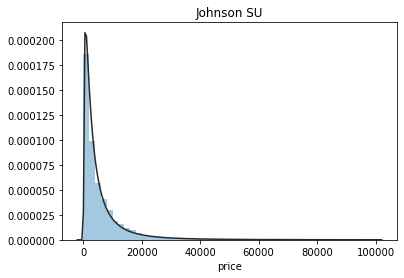

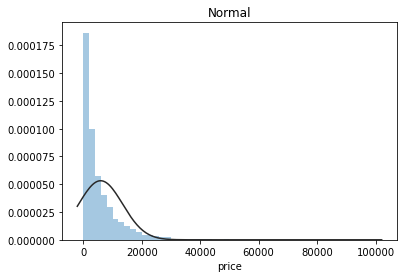

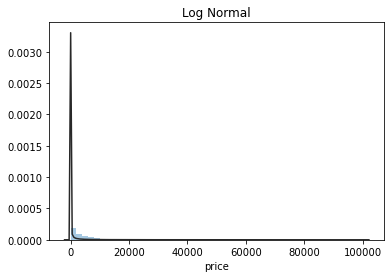

In [15]:
# 查看price的分布情况，用三种函数（无界约翰逊、正态、对数）进行拟合
y = Train_data['price']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

Optimal lambda value: 0.0818509672675628


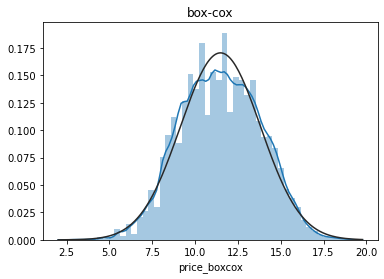

In [16]:
# box-cox拟合
price = np.array(Train_data['price'])
price_clean = price[~np.isnan(price)]
# 计算最佳λ值
l, opt_lambda = st.boxcox(price_clean)
print('Optimal lambda value:', opt_lambda)

# 进行Box-Cox变换
Train_data['price_boxcox'] = st.boxcox(Train_data['price'],lmbda=opt_lambda)
plt.figure(1); plt.title('box-cox')
# sns.distplot(y, kde=False, fit=st.norm)
sns.distplot(Train_data['price_boxcox'], fit=st.norm)

In [17]:
date_cols = ['regDate', 'creatDate']
cate_cols = ['name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'regionCode', 'seller', 'offerType']
num_cols = ['power', 'kilometer'] + ['v_{}'.format(i) for i in range(15)]
cols = date_cols + cate_cols + num_cols

tmp = pd.DataFrame()
tmp['count'] = Train_data[cols].count().values
tmp['missing_counts'] = Train_data.shape[0] - tmp['count']
tmp['missing_rate'] = (Train_data.shape[0] - tmp['count']) / Train_data.shape[0]
tmp['nunique'] = Train_data[cols].nunique().values
tmp['max_value_counts'] = [Train_data[f].value_counts().values[0] for f in cols]
tmp['max_value_counts_prop'] = tmp['max_value_counts'] / Train_data.shape[0]
tmp['max_value_counts_value'] = [Train_data[f].value_counts().index[0] for f in cols]
tmp.index = cols
tmp

,count,missing_counts,missing_rate,nunique,max_value_counts,max_value_counts_prop,max_value_counts_value
regDate,150000,0,0.000000,3894,180,0.001200,20000008
creatDate,150000,0,0.000000,96,5848,0.038987,20160403
name,150000,0,0.000000,99662,282,0.001880,708
model,149999,1,0.000007,248,11762,0.078413,0
brand,150000,0,0.000000,40,31480,0.209867,0
bodyType,145494,4506,0.030040,8,41420,0.276133,0
fuelType,141320,8680,0.057867,7,91656,0.611040,0
gearbox,144019,5981,0.039873,2,111623,0.744153,0
notRepairedDamage,150000,0,0.000000,3,111361,0.742407,0.0
regionCode,150000,0,0.000000,7905,369,0.002460,419


###  基本信息查看完后（这里没有具体查看各个特征的value_counts，notRepairedDamage里面有符号‘-’需要替换成np.nan）后续合并后将一起操作。



In [18]:
# reduce_mem_usage 函数通过调整数据类型，帮助我们减少数据在内存中占用的空间
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} byte'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} byte'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [19]:
import gc
# 合并训练集和测试集,并减少内存
df = reduce_mem_usage(pd.concat([Train_data, Test_data], axis=0, ignore_index=True))
# del , test_df
# 清理内存
gc.collect()
df.head().append(df.tail())

Memory usage of dataframe is 51200128.00 byte
Memory usage after optimization is: 14000232.00 byte
Decreased by 72.7%


,SaleID,bodyType,brand,creatDate,fuelType,gearbox,kilometer,model,name,notRepairedDamage,offerType,power,price,price_boxcox,regDate,regionCode,seller,v_0,v_1,v_10,v_11,v_12,v_13,v_14,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9
0,0,1.0,6,20160404,0.0,0.0,12.5,30.0,736,0.0,0,60,1850.0,10.398438,20040402,1046,0,43.34375,3.966797,-2.880859,2.804688,-2.419922,0.795410,0.914551,0.050262,2.160156,1.143555,0.235718,0.101990,0.129517,0.022812,0.097473
1,1,2.0,1,20160309,0.0,0.0,15.0,40.0,2262,-,0,0,3600.0,11.664062,20030301,4366,0,45.31250,5.234375,-4.902344,2.095703,-1.030273,-1.722656,0.245483,0.137939,1.380859,-1.421875,0.264893,0.121033,0.135742,0.026596,0.020584
2,2,1.0,15,20160402,0.0,0.0,12.5,115.0,14874,0.0,0,163,6222.0,12.757812,20040403,2806,0,45.96875,4.824219,-4.847656,1.803711,1.565430,-0.832520,-0.229980,1.319336,-0.998535,-0.997070,0.251465,0.114929,0.165161,0.062164,0.027069
3,3,0.0,10,20160312,0.0,1.0,15.0,109.0,71865,0.0,0,193,2400.0,10.882812,19960908,434,0,45.68750,4.492188,-4.507812,1.286133,-0.501953,-2.437500,-0.478760,-0.050629,0.883789,-2.228516,0.274414,0.110291,0.121948,0.033386,0.000000
4,4,1.0,5,20160313,0.0,0.0,5.0,110.0,111080,0.0,0,68,5200.0,12.390625,20120103,6977,0,44.37500,2.031250,-1.896484,0.910645,0.931152,2.833984,1.923828,0.572266,-1.571289,2.246094,0.228027,0.073181,0.091858,0.078796,0.121521
199995,199995,4.0,4,20160320,0.0,0.0,15.0,4.0,20903,0.0,0,116,NaN,NaN,19960503,3219,0,45.62500,5.957031,-5.976562,1.302734,-1.207031,-1.981445,-0.357666,-0.918457,0.774902,-2.021484,0.284668,0.130005,0.049835,0.028809,0.004616
199996,199996,0.0,0,20160329,0.0,0.0,15.0,0.0,708,0.0,0,75,NaN,NaN,19991011,1857,0,43.93750,4.476562,-3.914062,1.759766,-2.076172,-1.155273,0.169067,-0.841797,1.328125,-1.292969,0.268066,0.108093,0.066040,0.025467,0.025970
199997,199997,0.0,1,20160305,1.0,1.0,15.0,49.0,6693,0.0,0,224,NaN,NaN,20040412,3452,0,46.53125,4.171875,-4.640625,0.654785,1.137695,-1.390625,0.254395,0.388672,-0.704590,-1.480469,0.269531,0.105713,0.117676,0.057465,0.015671
199998,199998,0.0,1,20160404,0.0,1.0,15.0,27.0,96900,0.0,0,334,NaN,NaN,20020008,1998,0,46.78125,-3.296875,1.833984,-2.828125,2.464844,-0.911621,-2.056641,0.243530,-1.277344,-0.404785,0.261230,0.000490,0.137329,0.086243,0.051392
199999,199999,1.0,6,20160322,NaN,1.0,9.0,166.0,193384,0.0,0,68,NaN,NaN,20041109,3276,0,43.71875,-3.121094,2.914062,-1.135742,0.547852,2.093750,-1.551758,0.027344,-0.809082,2.117188,0.228760,0.000300,0.103516,0.080627,0.124268


In [20]:
# 查看缺失值位置, 由下面可以看出利用合并后的查看缺失值索引更复杂
# 推荐分开查找，合并后的可以直接删除
Train_data[Train_data['model'].isnull().values==True]

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,offerType,creatDate,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,price_boxcox
38424,38424,148730,20150809,NaN,37,6.0,1.0,1.0,190,2.0,0.0,1425,0,0,20160320,47950,41.139365,-2.167089,-3.436008,-7.275037,6.829352,0.181562,0.002092,0.0,0.148487,0.222787,1.6757,-3.25056,0.876001,11.147669,8.658418,17.301783


In [21]:
Train_data[Train_data['bodyType'].isnull().values==True].index.tolist()

[14,
 125,
 154,
 188,
 199,
 224,
 227,
 360,
 412,
 462,
 487,
 495,
 567,
 682,
 691,
 771,
 841,
 1045,
 1056,
 1103,
 1209,
 1230,
 1231,
 1280,
 1296,
 1373,
 1397,
 1419,
 1480,
 1534,
 1584,
 1633,
 1656,
 1657,
 1663,
 1681,
 1683,
 1689,
 1711,
 1729,
 1735,
 1751,
 1758,
 1773,
 1777,
 1795,
 1825,
 1858,
 1886,
 1930,
 1967,
 2036,
 2086,
 2124,
 2154,
 2181,
 2254,
 2298,
 2318,
 2324,
 2338,
 2423,
 2442,
 2494,
 2506,
 2512,
 2593,
 2608,
 2624,
 2688,
 2739,
 2867,
 2880,
 2896,
 2897,
 2910,
 2947,
 2959,
 2987,
 3017,
 3038,
 3059,
 3110,
 3117,
 3145,
 3157,
 3256,
 3298,
 3303,
 3342,
 3345,
 3374,
 3433,
 3436,
 3438,
 3447,
 3482,
 3490,
 3518,
 3540,
 3544,
 3602,
 3685,
 3724,
 3769,
 3785,
 3840,
 3887,
 3901,
 3955,
 3971,
 3976,
 3991,
 4104,
 4151,
 4169,
 4228,
 4245,
 4270,
 4365,
 4410,
 4431,
 4471,
 4505,
 4598,
 4611,
 4695,
 4700,
 4707,
 4716,
 4731,
 4735,
 4744,
 4878,
 4885,
 4889,
 4971,
 5026,
 5035,
 5040,
 5088,
 5103,
 5104,
 5113,
 5144,
 51

df[~df['price'].isnull()][df[~df['price'].isnull()]['bodyType'].isnull().values==True]
用这个方法耗时

In [22]:
df['notRepairedDamage'].replace('-', np.nan, inplace=True)

In [23]:
df['notRepairedDamage'].value_counts()

0.0    148610
1.0     19035
-           0
Name: notRepairedDamage, dtype: int64

In [24]:
df['notRepairedDamage'].isnull().sum()

32355

In [25]:
# 对邮编进行处理
df['city'] = df['regionCode'].apply(lambda x : int(str(x)[:2]))
del df['regionCode']

In [26]:
# 先对时间进行处理
def used_time(a, b):
    age = []
    for i in range(len(a)):
        age0 = a[i] - b[i]
        age1 = round((age0//10000 + (age0/1000-age0//10000*10)/12)*365, 1)
        age.append(age1)
    return age

In [27]:
df['used_time'] = used_time(df.creatDate, df.regDate)

In [28]:
# 开始删除无用的特征
# df.drop(['creatDate', '', ''], axis=1, inplace=True)
# 这里用del更加直观
del df['SaleID'], df['name'], df['creatDate'], df['regDate'], df['seller'], df['offerType']


上面处理了邮编、删除了与price预测无关的几个特征，新加入一个used_time特征；并把notrepairedDamage的特殊符号处理为空

（1）model特征的38424可以删除；
（2）bodyType、fuelType、gearbox三个特征的缺失值先用中位数填充

In [29]:
df.drop(df.index[38424], inplace=True) 
print('均值、中位数、众数：',df[~df['price'].isnull()]['bodyType'].mean(),df[~df['price'].isnull()]['bodyType'].median(),df[~df['price'].isnull()]['bodyType'].mode()[0])

均值、中位数、众数： nan 1.0 0.0


发现类别特征不能这样处理

In [30]:
df.shape

(199999, 27)

#### 来看一下各个数值特征跟price的相关性。跟price相关性比较高的有汽车注册年份（regDate_year），应该可以理解为车越新，价格越高；汽车已行驶公里数（kilometer）也还行，应该可以理解为跑的路程越多，车就越旧，价格就越低；匿名特征里面的v_0、v_3、v_8、v_12看起来跟price的相关性很高，原因就不知道了。除了跟price的相关性，还可以发现有些特征跟特征之间的相关性也很高，比如v_1跟v_6、v_2跟v_7、v_3跟v_8、v_4跟v_9等，这些特征之间可能存在冗余现象，训练的时候可以依据效果尝试去掉一部分，或者拆分成两部分，做模型融合。

In [31]:
cate_cols1 = ['model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'city']
num_cols1 = ['power', 'kilometer', 'used_time'] + ['v_{}'.format(i) for i in range(15)]
cols1 = cate_cols1 + num_cols1

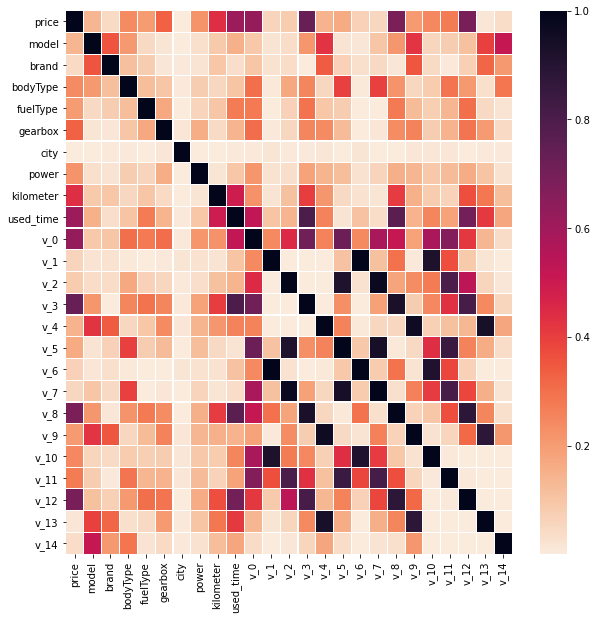

In [32]:
# 全部特征
corr0 = abs(df[~df['price'].isnull()][['price'] + cols1].corr())
plt.figure(figsize=(10, 10))
sns.heatmap(corr0, linewidths=0.1, cmap=sns.cm.rocket_r)

In [33]:
corr0

,price,model,brand,bodyType,fuelType,gearbox,city,power,kilometer,used_time,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
price,1.000000,0.136983,0.043943,0.241242,0.200514,0.329043,0.001904,0.219842,0.440475,0.612203,0.628502,0.060943,0.085375,0.730920,0.147331,0.164390,0.069008,0.053007,0.685776,0.206408,0.246217,0.275312,0.692883,0.014320,0.035611
model,0.136983,1.000000,0.358765,0.207208,0.048767,0.019314,0.000147,0.031245,0.087445,0.148888,0.091021,0.019805,0.037684,0.215659,0.426662,0.019703,0.015419,0.100752,0.211152,0.423526,0.058673,0.079661,0.110157,0.400002,0.513733
brand,0.043943,0.358765,1.000000,0.114063,0.079600,0.012867,0.005406,0.022401,0.096202,0.033087,0.101190,0.025565,0.036078,0.000494,0.343668,0.069176,0.031166,0.050009,0.015126,0.352065,0.043214,0.007596,0.070923,0.320816,0.207977
bodyType,0.241242,0.207208,0.114063,1.000000,0.118701,0.099938,0.006904,0.079627,0.053169,0.102953,0.303563,0.010086,0.172335,0.250747,0.053073,0.398467,0.009360,0.399395,0.220267,0.051851,0.082719,0.293002,0.210036,0.030826,0.289108
fuelType,0.200514,0.048767,0.079600,0.118701,1.000000,0.171680,0.001168,0.059312,0.099471,0.276474,0.280000,0.002658,0.067684,0.293100,0.095121,0.081480,0.001506,0.000494,0.279352,0.128767,0.075222,0.137748,0.302331,0.049753,0.021728
gearbox,0.329043,0.019314,0.012867,0.099938,0.171680,1.000000,0.011974,0.156703,0.046774,0.142850,0.306746,0.004289,0.054430,0.253998,0.238842,0.124357,0.002211,0.011885,0.238352,0.258097,0.080566,0.145913,0.291373,0.204007,0.044321
city,0.001904,0.000147,0.005406,0.006904,0.001168,0.011974,1.000000,0.001377,0.001497,0.004342,0.005593,0.017567,0.004541,0.004482,0.013044,0.002573,0.017111,0.002208,0.002538,0.014688,0.013439,0.012140,0.000526,0.004666,0.005781
power,0.219842,0.031245,0.022401,0.079627,0.059312,0.156703,0.001377,1.000000,0.019624,0.097780,0.215016,0.023749,0.031484,0.185341,0.141043,0.119727,0.025651,0.060396,0.155952,0.140223,0.092718,0.122104,0.161990,0.103479,0.023836
kilometer,0.440475,0.087445,0.096202,0.053169,0.099471,0.046774,0.001497,0.019624,1.000000,0.492558,0.225063,0.022239,0.110399,0.402464,0.214787,0.049478,0.024680,0.017845,0.407653,0.149355,0.083369,0.066526,0.370157,0.285082,0.120269
used_time,0.612203,0.148888,0.033087,0.102953,0.276474,0.142850,0.004342,0.097780,0.492558,1.000000,0.526329,0.104391,0.140780,0.797265,0.259699,0.021994,0.107716,0.038799,0.761967,0.145905,0.250963,0.186142,0.704504,0.411966,0.177716


In [36]:
path = 'I:/old_cars/EDA/'
corr0.to_csv('corr0.csv')

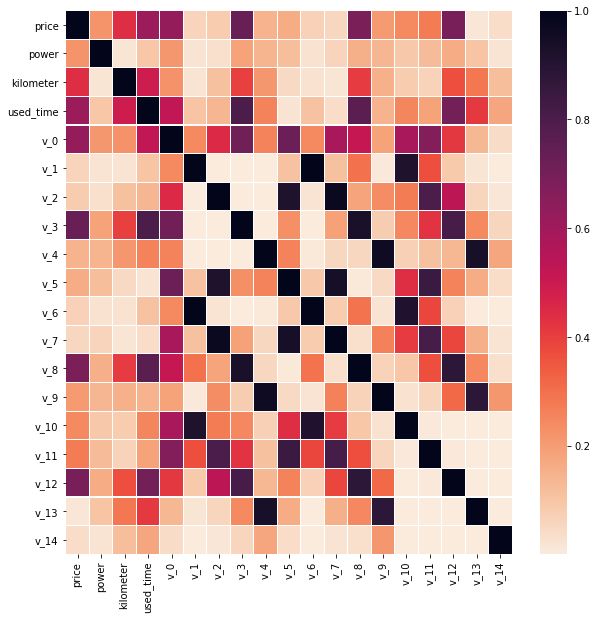

In [178]:
# 只有数字特征
corr1 = abs(df[~df['price'].isnull()][['price'] + num_cols1].corr())
plt.figure(figsize=(10, 10))
sns.heatmap(corr1, linewidths=0.1, cmap=sns.cm.rocket_r)

接下来看看15维匿名特征分别在训练集和测试集上的分布，如果发现分布不一致的，可以尝试处理。但是貌似这15维特征在训练集和测试集上的分布基本上都挺一致的，无论多奇怪的分布，两个数据集上都挺一致。

In [179]:
# plt.figure()
# plt.figure(figsize=(15, 15))
# i = 1
# for f in num_cols[2:]:
#     plt.subplot(5, 3, i)
#     i += 1                                                             
#     sns.distplot(df[~df['price'].isnull()][f], label='train', color='y', hist=False)
#     sns.distplot(df[df['price'].isnull()][f], label='test', color='g', hist=False)
# plt.tight_layout()
# plt.show()

<Figure size 432x288 with 0 Axes>

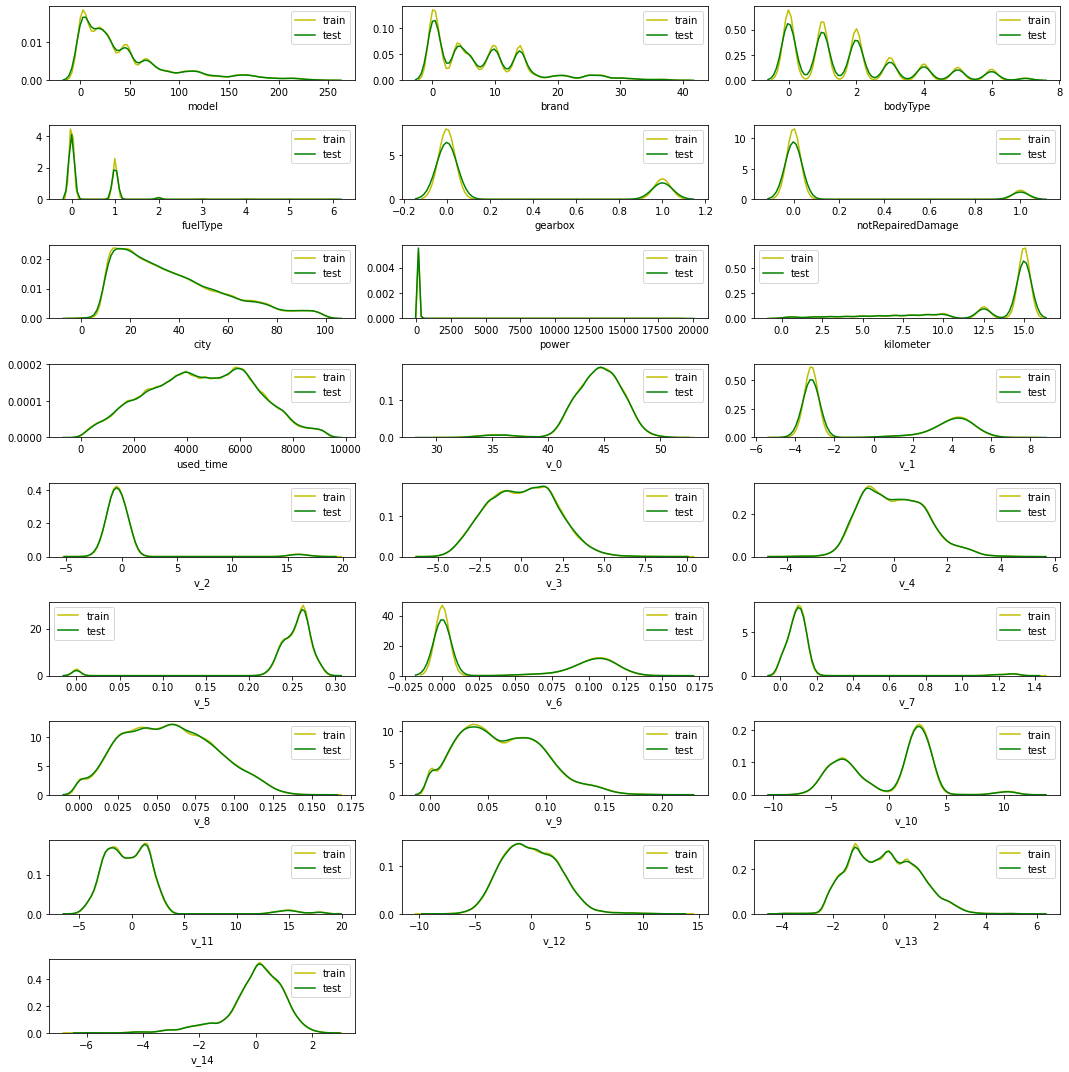

In [180]:
# 查看所有特征
plt.figure()
plt.figure(figsize=(15, 15))
i = 1
for f in cols1:
    plt.subplot(9, 3, i)
    i += 1                                                             
    sns.distplot(df[~df['price'].isnull()][f], label='train', color='y', hist=False)
    sns.distplot(df[df['price'].isnull()][f], label='test', color='g', hist=False)
plt.tight_layout()
plt.show()

简单看几个n unique比较小的特征上面的price的均值的分布。可以发现kilometer的趋势变化很明显，这也对应了上面的相关性分布，这个特征跟price的相关性挺高。kilometer应该是被离散化过的，只保留了整数。

<Figure size 432x288 with 0 Axes>

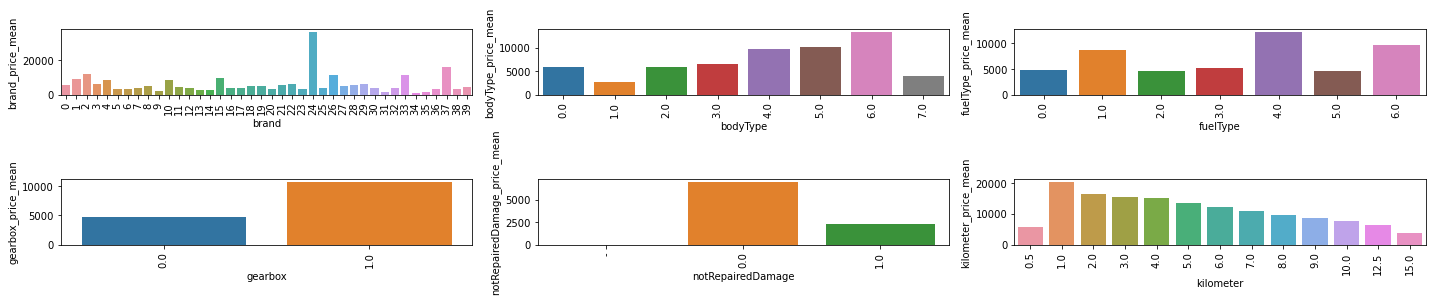

In [181]:
plt.figure()
plt.figure(figsize=(20, 18))
i = 1
for f in cols1:
    if df[f].nunique() <= 50:
        plt.subplot(9, 3, i)
        i += 1
        v = df[~df['price'].isnull()].groupby(f)['price'].agg({f + '_price_mean': 'mean'}).reset_index()
        fig = sns.barplot(x=f, y=f + '_price_mean', data=v)
        for item in fig.get_xticklabels():
            item.set_rotation(90)
plt.tight_layout()
plt.show()

#### 对训练集power处理[0,600]
(1)训练集删除，测试集截断到600

(2)填充为np.nan，按照缺失值进行处理

注：查看发现好多值为0，但是训练集和测试集一致，就不管了

In [182]:
# 替换大于600的数为缺失值·
df.power[df['power']>600]=np.nan

In [183]:
df['power'].value_counts()

0.0      17024
75.0     12819
150.0     8675
60.0      8538
140.0     7912
101.0     7416
116.0     6893
90.0      6590
170.0     6372
105.0     5976
125.0     3917
136.0     3792
163.0     3703
102.0     3687
143.0     3284
122.0     3065
54.0      3059
131.0     2997
109.0     2801
110.0     2698
50.0      2342
177.0     2293
80.0      2270
120.0     2173
58.0      2169
69.0      1981
115.0     1711
95.0      1676
184.0     1655
86.0      1601
45.0      1566
68.0      1560
193.0     1461
204.0     1425
179.0     1422
231.0     1408
218.0     1392
160.0     1368
82.0      1319
224.0     1300
200.0     1252
65.0      1196
190.0     1002
55.0       988
192.0      950
64.0       872
71.0       830
88.0       815
174.0      813
129.0      780
211.0      748
100.0      738
107.0      731
197.0      710
147.0      683
306.0      673
245.0      668
239.0      646
118.0      597
61.0       583
156.0      573
145.0      572
84.0       556
272.0      555
155.0      538
103.0      538
98.0      

In [184]:
# 查看power缺失值情况，运行太慢就查看了全部
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199999 entries, 0 to 199999
Data columns (total 27 columns):
bodyType             194080 non-null float16
brand                199999 non-null int8
fuelType             188426 non-null float16
gearbox              192108 non-null float16
kilometer            199999 non-null float16
model                199999 non-null float16
notRepairedDamage    167644 non-null category
power                199786 non-null float64
price                149999 non-null float32
price_boxcox         149999 non-null float16
v_0                  199999 non-null float16
v_1                  199999 non-null float16
v_10                 199999 non-null float16
v_11                 199999 non-null float16
v_12                 199999 non-null float16
v_13                 199999 non-null float16
v_14                 199999 non-null float16
v_2                  199999 non-null float16
v_3                  199999 non-null float16
v_4                  199999 non-null

## 箱线图删除异常点，先查看散点图
再进行特征构造：（1）类别特征进行one-hot编码（2）数字特征构造高阶函数

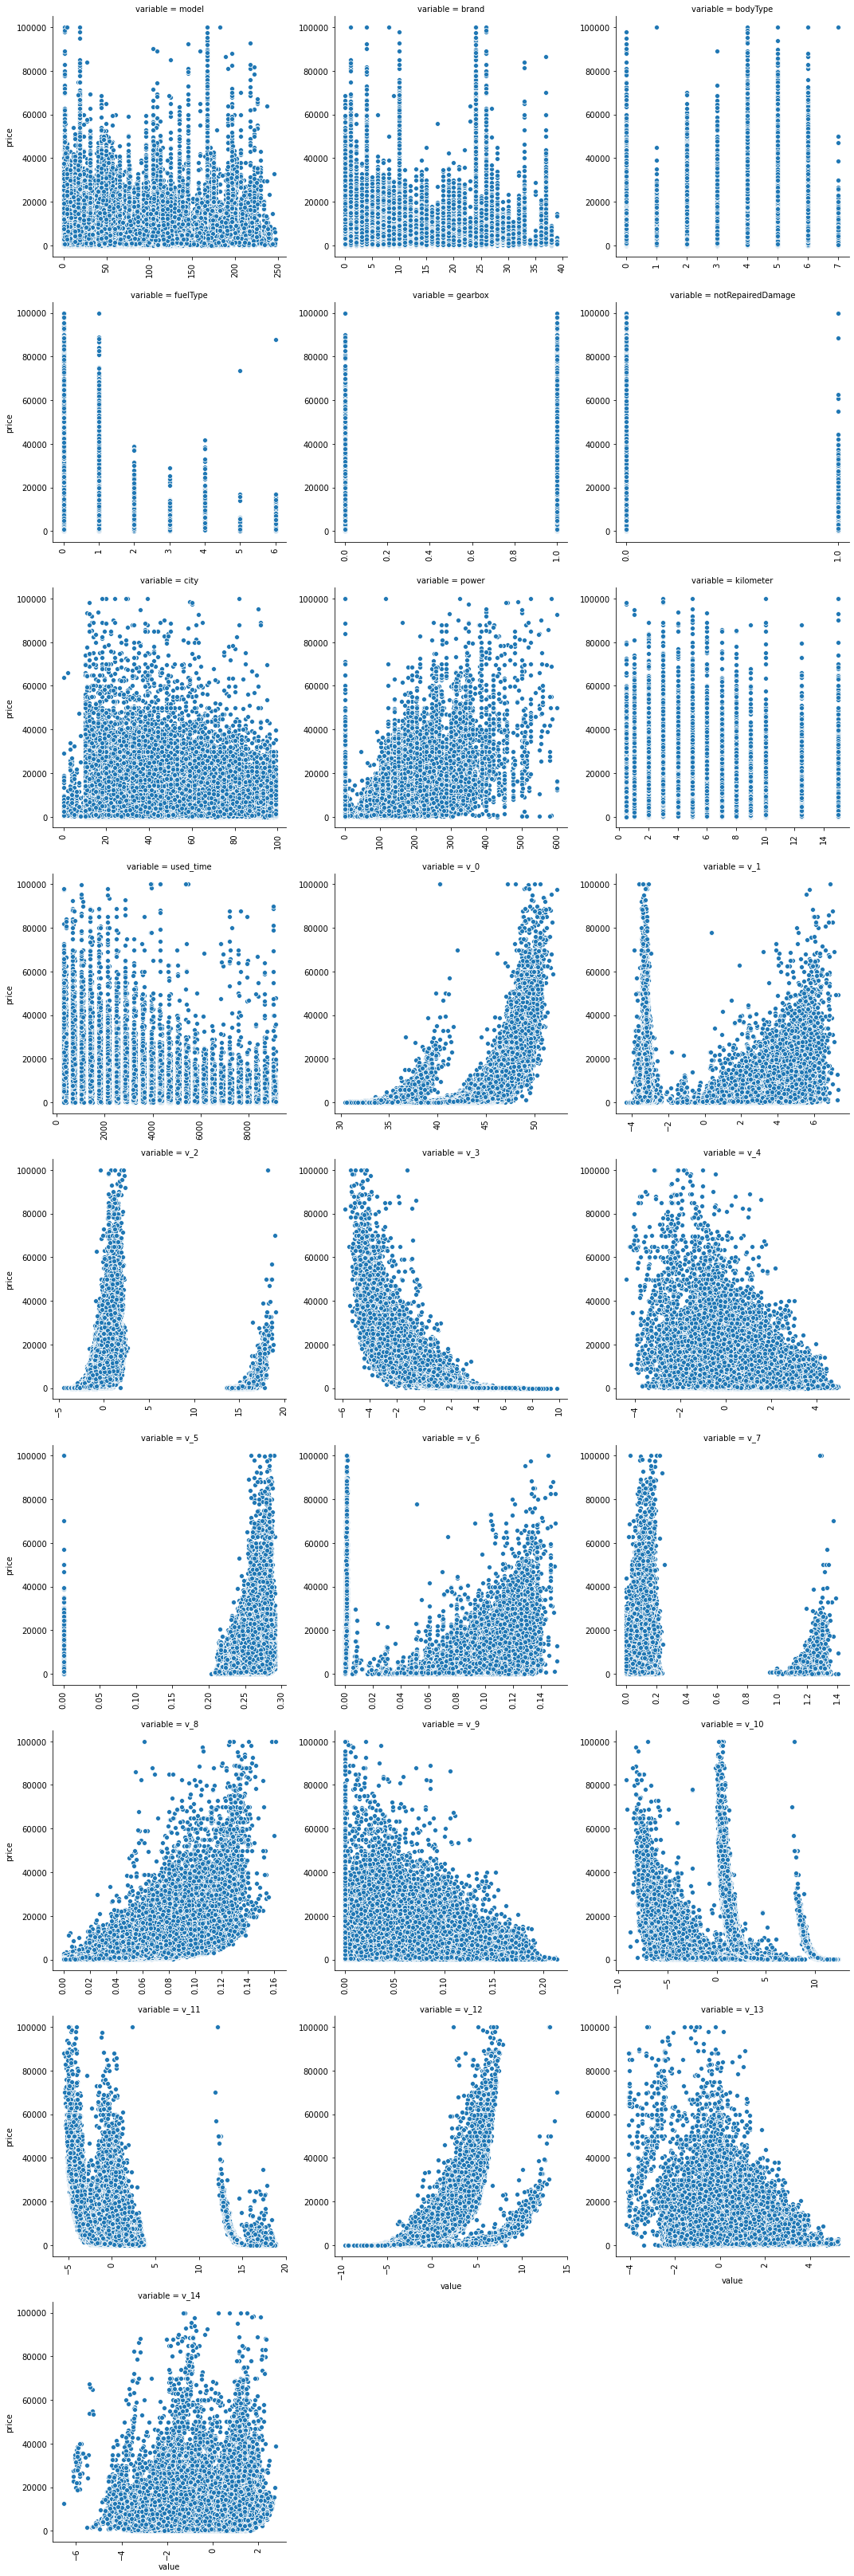

In [185]:
# 散点图
def scatterplot(x, y, **kwargs):
    sns.scatterplot(x=x, y=y)
    x = plt.xticks(rotation=90)
f = pd.melt(df[~df['price'].isnull()], id_vars=['price'],value_vars=cols1)
g = sns.FacetGrid(f, col='variable', col_wrap=3, sharex=False, sharey=False, size=5)
g = g.map(scatterplot, 'value', 'price')

#### 如何确定这些异常值？我们采取了不同特征不同标准的策略。一般认为1.5*（Q3-Q1）以外3的取值为异常，其中Q3和Q1为数据的较大四分位和较小四分位。在比赛中，我们设置的q*(Q3-Q1)，q的取值1.4、1.5、10或者其他值。
确定异常数据后，对这些异常数据的不同处理方式会影响后续算法的表现。一般大家都会想到，使用平均值、前值、特殊值填充等策略，具体哪种好，可能需要具体场景下多试几次才知道

Delete number is: 0
Now column number is: 149999
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: v_14, dtype: float64
Description of data larger than the upper bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: v_14, dtype: float64
箱型图删除异常值后： (149999, 27)
Delete number is: 0
Now column number is: 149999
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: v_14, dtype: float64
Description of data larger than the upper bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: v_14, dtype: float64
箱型图删除异常值后： (149999, 27)
Delete number is: 969
Now column number is: 149030
Description of data less than the lower bound is:
count    969.000000
mean 

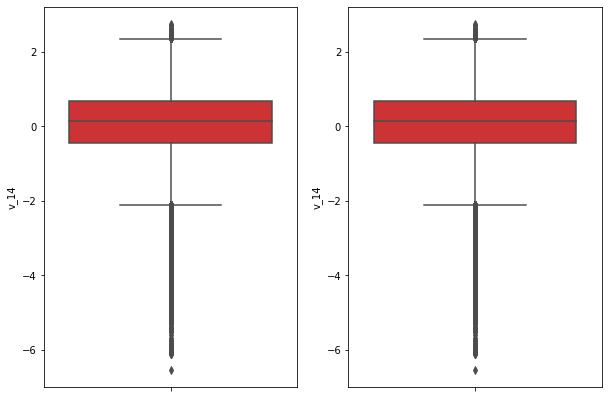

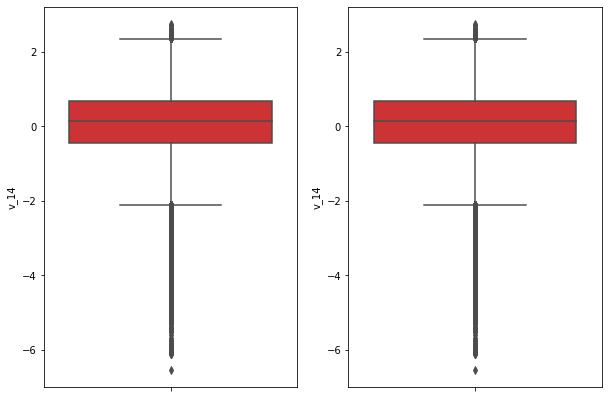

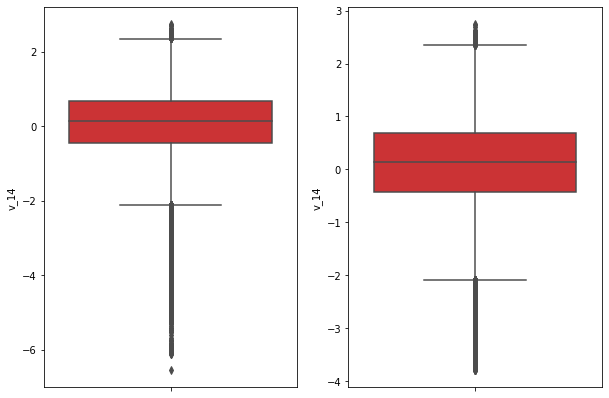

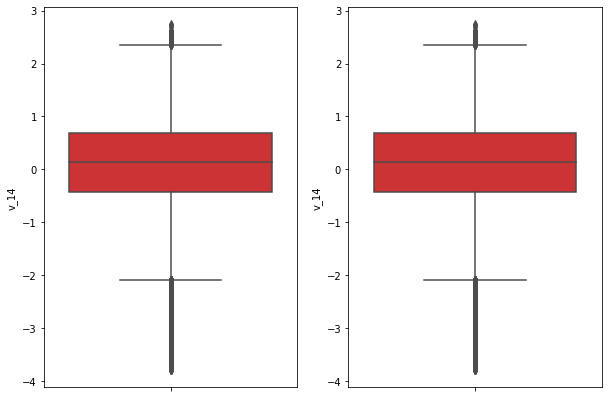

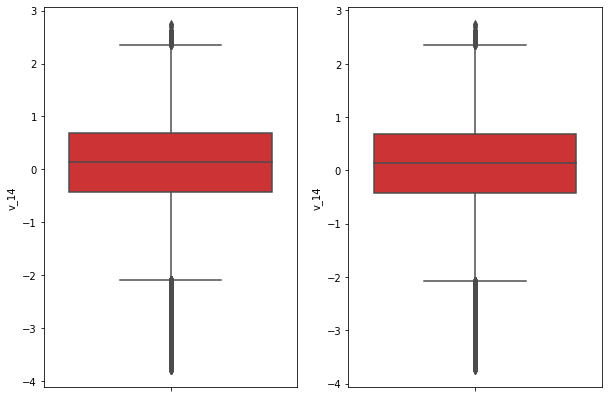

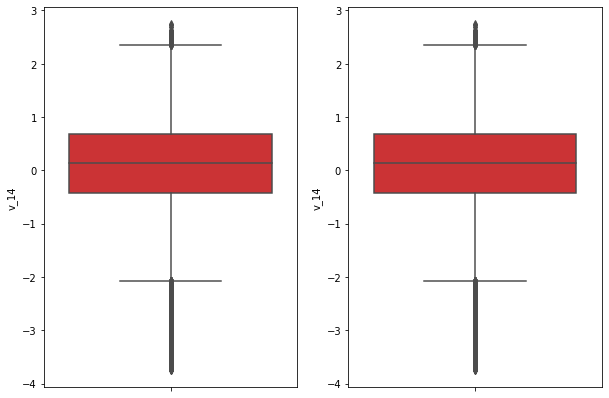

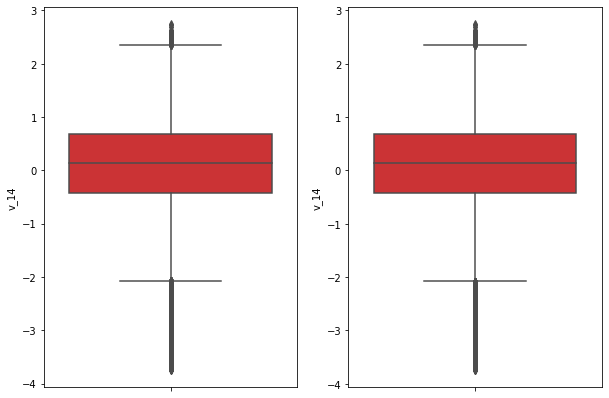

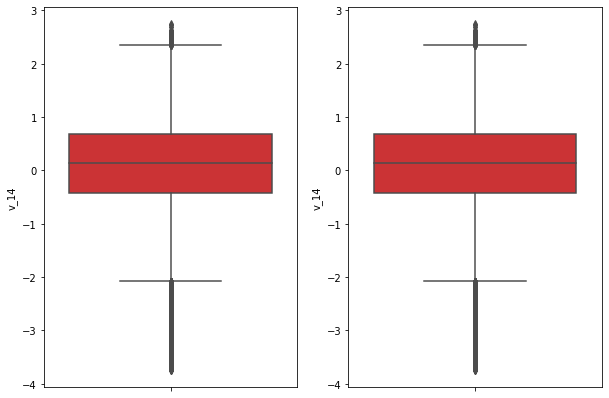

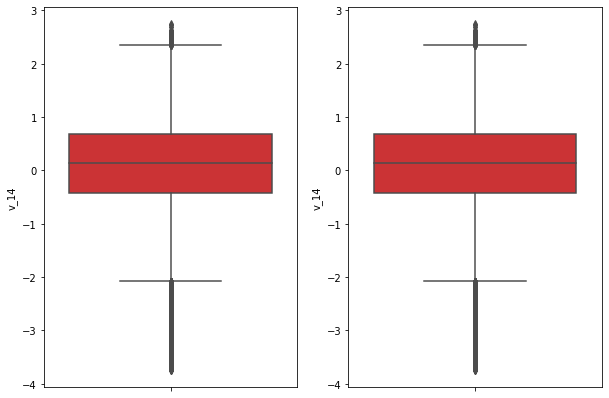

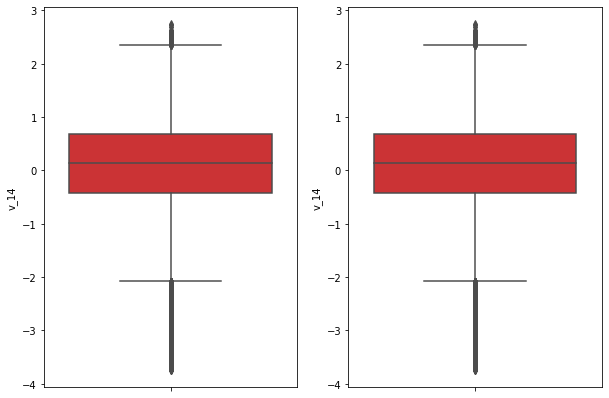

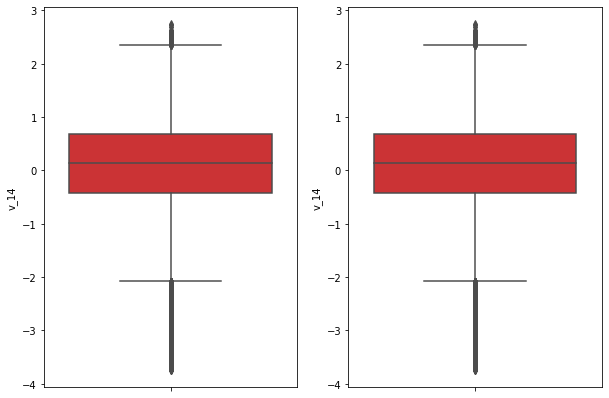

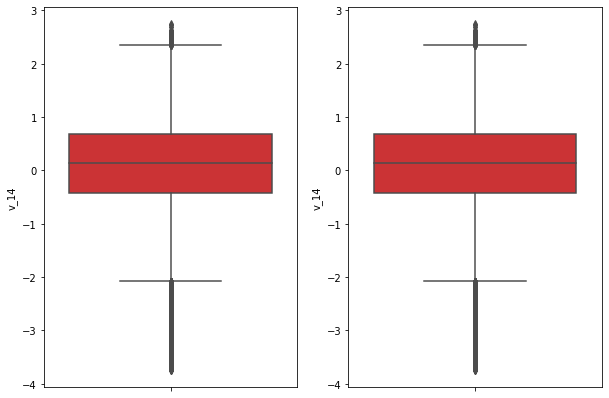

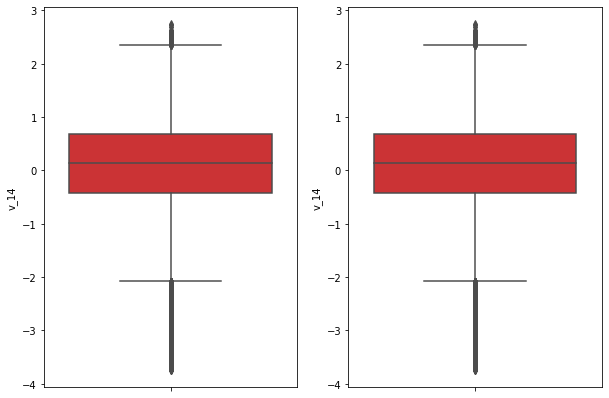

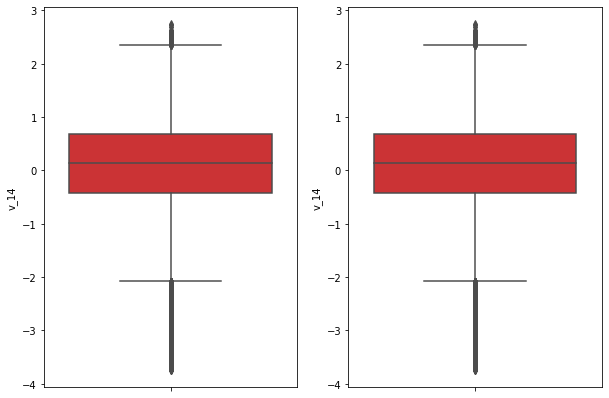

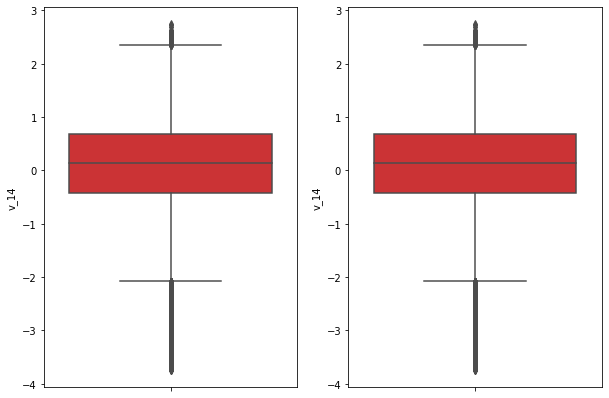

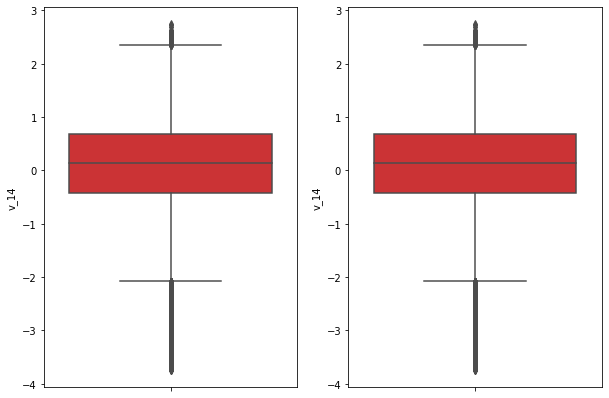

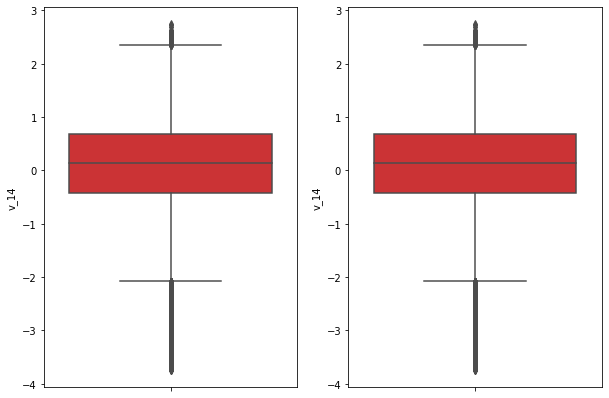

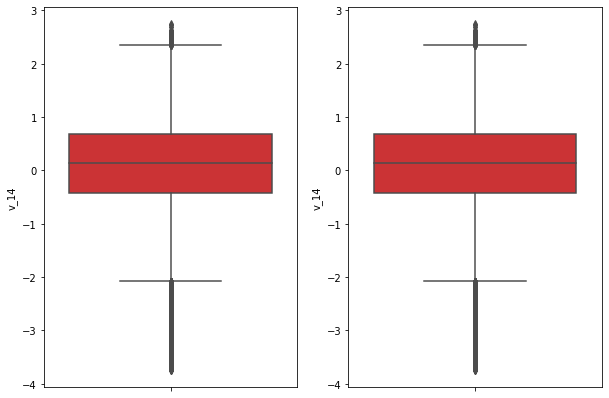

In [186]:
# 数据预处理，去除异常点
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# 这里我包装了一个异常值处理的代码，可以随便调用。
def outliers_proc(data, col_name, scale, df):
    """
    用于清洗异常值，默认用 box_plot（scale=3）进行清洗
    :param data: 接收 pandas 数据格式
    :param col_name: pandas 列名
    :param scale: 尺度
    :return:
    """

    def box_plot_outliers(data_ser, box_scale):
        """
        利用箱线图去除异常值
        :param data_ser: 接收 pandas.Series 数据格式
        :param box_scale: 箱线图尺度，
        :return:
        """
        iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        val_low = data_ser.quantile(0.25) - iqr
        val_up = data_ser.quantile(0.75) + iqr
        rule_low = (data_ser < val_low)
        rule_up = (data_ser > val_up)
        return (rule_low, rule_up), (val_low, val_up)
    data_n = data.copy()
    data_series = data_n[col_name]
    rule, value = box_plot_outliers(data_series, box_scale=scale)
    index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
    print("Delete number is: {}".format(len(index)))
#     print('删除的索引值为：', index)
#     del_idx = len(index)
    data_n = data_n.drop(index)
    data_n.reset_index(drop=True, inplace=True)
    df_n = df.drop(index)
    df_n.reset_index(drop=True, inplace=True)
    print("Now column number is: {}".format(data_n.shape[0]))
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print("Description of data less than the lower bound is:")
    print(pd.Series(outliers).describe())
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print("Description of data larger than the upper bound is:")
    print(pd.Series(outliers).describe())
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.boxplot(y=data[col_name], data=data, palette="Set1", ax=ax[0])
    sns.boxplot(y=data_n[col_name], data=data_n, palette="Set1", ax=ax[1])
    return data_n, index, df_n


# def scale(features,scaler):

#     scaler.fit(features)
#     scaled_features=scaler.transform(features)
#     return scaled_features,scaler

# print('加载数据...')
# path = 'I:/old_cars/data/'
# Train_data = pd.read_csv(path + 'used_car_train_20200313.csv', sep=' ')    
# print(['原始训练数据：',Train_data.shape])
# Test_data = pd.read_csv(path + 'used_car_testA_20200313.csv', sep=' ')
# print(['测试数据：',Test_data.shape])

# df = pd.concat([Train_data, Test_data], axis=0, ignore_index=True)
# print('合并后的数据：',df.shape)
# age = []
# for i in range(len(df)):
#     age0 = df.creatDate[i] - df.regDate[i]
#     age1 = round((age0//10000 + (age0/1000-age0//10000*10)/12)*365, 1)
#     age.append(age1)
# df['used_time'] = age
# df.drop(['regDate', 'creatDate', 'name', 'SaleID', 'seller', 'offerType'], axis=1, inplace=True)
# print('删除无效特征后数据：', df.shape)
numeric_features = num_cols = ['power', 'kilometer', 'used_time'] + ['v_{}'.format(i) for i in range(15)]
# del_index = []
scale = [1000, 1000, 3, 4, 3, 1000, 3, 3, 1000, 3, 1000, 3, 3, 3, 1000, 3, 3, 1000]
for i,sca in enumerate(numeric_features):
    data, index, df_n=outliers_proc(df[~df['price'].isnull()], col, scale[i], df)
#       del_index.append(del_idx)
#       suoyin.append(index)
#     print('各特征删除的数量：',del_index)
    df = df_n
    print('箱型图删除异常值后：', data.shape)
#     data_prc.to_csv('data_prc_lstm.csv',index=None)
print('数据预处理完毕,数据大小为：', df.shape)

del_index[963, 10159, 0, 1200, 0, 4506, 0, 1, 4506, 0, 4506, 0, 0, 0, 4506, 7, 1, 970]

In [187]:
df.to_csv('pre_data.csv')